# Pre-processing of Hepatocytes Data

- Reference: https://www.nature.com/articles/nature21065
- Data (`table_s1_reform.txt`) downloaded from: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE84498
- The log-transformed and scaled data is stored within a `tmp_dir` for subsequent analysis
    - `x_data.npy`: the landmark genes
    - `y_data.npy`: all variable genes under consideration
    - `obs_info.npy`: meta information of each cell
    - `var_info.npy`: meta information of each gene/variable

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib as mpl
from IPython.display import display
import sys
sys.path.insert(0,'../src')
mpl.rcParams['figure.dpi']= 100

In [2]:
import numpy as np
import pandas as pd
import os
import pickle
import scanpy.api as sc
import time
import seaborn as sns
import matplotlib.pyplot as plt
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

scanpy==1.4.3 anndata==0.6.20 umap==0.3.9 numpy==1.15.2 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.20.0 statsmodels==0.9.0 


## Gene expression data - supposed already background removed

We work with adata after transform filter (with fewer genes and variance stablizing transformation):
- `load_hepatocyte_data()` parses the raw data file, and
- `transform_filter_anndata()` performs the transformation

The second function optionally regress out the effect of the cell size for all the values in the data matrix.

The scaled and normalized data will be saved in directories: 
 - `{dat_dir}/analysis_on_scaled/data`, and 
 - `{dat_dir}/analysis_on_scaled_size_norm/dat` respectively.

In [3]:
from plot_utils import plot_scatter_discrete, plot_scatter_continuous
from liver_info import get_known_liver_markers, load_hepatocyte_data
from liver_info import save_processed_data, save_x_y_data
from scrna_utils import transform_filter_anndata
from sim_utils import scale_corr_input, batch_comp_dist_corr
from graph_utils import laplacian_score, construct_kernal_graph
from general_utils import norm_mtx
from scrna_utils import write_unscaled_processed_data, summarize_gene_df

sample_name = "hepatocyte"
lm_genes = get_known_liver_markers()["zonation"]
dat_dir = "/Users/jjzhu/Google Drive/_GLISS/data/liver2k"


def plot_graph_w_ground_truth(lm_df, dat_dir):
    from liver_info import load_zonation_result
    from graph_utils import construct_kernal_graph, construct_knn_naive
    graph_in_dat = (lm_df - lm_df.mean()) / lm_df.std() # center and scale the zonation genes
    graph_in_dat["zone"] = load_zonation_result(dat_dir)
    graph_in_dat = graph_in_dat.sort_values(by="zone")
    kern_graph = construct_kernal_graph(graph_in_dat[lm_genes].values)
    knn_graph = construct_knn_naive(graph_in_dat[lm_genes].values)
    fig, ax = plt.subplots(1,2,figsize=(13,5))
    sns.heatmap(kern_graph.toarray(), xticklabels=False, yticklabels=False, ax=ax[0])
    sns.heatmap(knn_graph.toarray(), xticklabels=False, yticklabels=False, ax=ax[1])
    plt.show()
    
def scale_data_and_save(adata, lm_genes, tmp_dir):
    gene_scores = summarize_gene_df(adata)
    x = adata[:,lm_genes].X
    y = adata.X
    save_processed_data(tmp_dir, x, y, adata.obs, gene_scores)
    x_scaled = norm_mtx(x, center=True, scale=True)
    y_scaled = norm_mtx(y, center=True, scale=True)
    save_x_y_data(tmp_dir, x_scaled, y_scaled, "scaled")

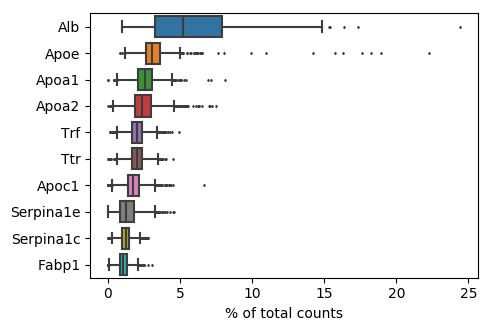

filtered out 16998 genes that are detected in less than 10 cells


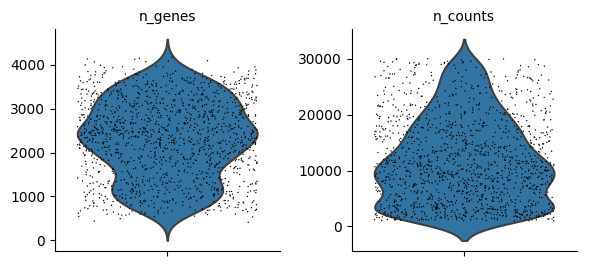

Filtered out: 16998 genes; remaining 10299


Trying to set attribute `.obs` of view, making a copy.


Filtered out: 0 doublet cells
View of AnnData object with n_obs × n_vars = 1415 × 10299 
    obs: 'n_genes', 'n_counts'
    var: 'gene_ids', 'n_cells'
Saved: x (1415, 6) and y (1415, 8883) at /Users/jjzhu/Google Drive/_GLISS/data/liver2k/analysis_on_data_original/data
Saved: x (1415, 6) and y (1415, 8883) at /Users/jjzhu/Google Drive/_GLISS/data/liver2k/analysis_on_data_original/data
       n_genes      n_counts
Cell1     1779   6726.214844
Cell2     3387  20066.574219
Cell3     2791  16297.222656
Cell4     2377  13083.556641
Cell5     2931  18036.222656
                                  gene_ids  n_cells      mean       std  npc
0610007C21Rik;Apr3      0610007C21Rik;Apr3      770  0.487967  0.527124  770
0610007L01Rik                0610007L01Rik      761  0.455494  0.506628  761
0610007P08Rik;Rad26l  0610007P08Rik;Rad26l       65  0.030682  0.159816   65
0610007P14Rik                0610007P14Rik      749  0.456374  0.518156  749
0610007P22Rik                0610007P22Rik       35  0

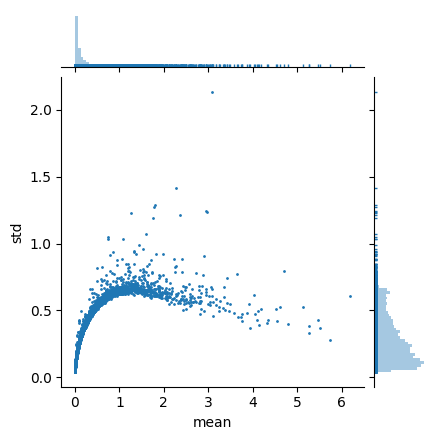

In [4]:
scale_pfx = "original"
tmp_dir = os.path.join(dat_dir, "analysis_on_data_{}".format(scale_pfx))
adata = load_hepatocyte_data(dat_dir, verbose=True)
adata = transform_filter_anndata(adata, scale_pfx=scale_pfx)
scale_data_and_save(adata, lm_genes, tmp_dir)

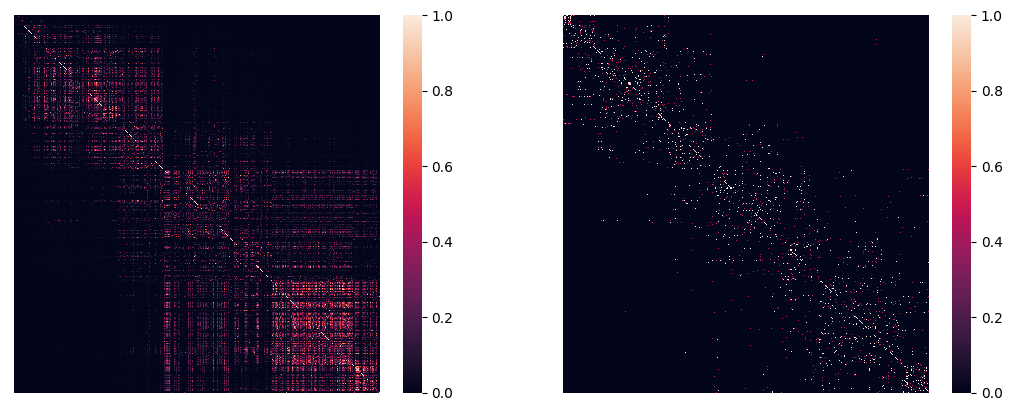

In [6]:
lm_log_expr = pd.DataFrame(adata[:, lm_genes].X, columns=lm_genes)
plot_graph_w_ground_truth(lm_log_expr, dat_dir)

## Test for loading the processed data

In [5]:
from liver_info import load_x_y_data
x, y, obs_df, var_df = load_x_y_data(tmp_dir, center=True, scale=True)

Data directory: /Users/jjzhu/Google Drive/_GLISS/data/liver2k/analysis_on_data_original/data
Loaded data: x (1415, 6) and y (1415, 8883)
